<a href="https://colab.research.google.com/github/pouyapanahandeh/vgg16-predict-car-label/blob/main/predict_car_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# use vgg16 to predict car label

## 0. Import libraries


In [1]:
# ADD YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

In [2]:
#load data from gd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#load data from google drive to run everywhere
# import gdown

# url = 'https://drive.google.com/drive/folders/1nYmD18KwomTb7H6IesooKyf5hbnuSPP6?usp=sharing'
# output = 'cars_train'
# gdown.download_folder(url, quiet=True, no_cookies=True)

In [3]:
dataset_dir = "/content/drive/MyDrive/cars_train/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)

testset = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)

#### Splitting the dataset

In [4]:
# ADD YOUR CODE HERE
# obtain training indices that will be used for validation
valid_size = 0.2
batch_size = 32
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#### Pre-processing the dataset

In [5]:
# ADD YOUR CODE HERE
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=False, num_workers = 2)

#### Loading the dataset
Show some images and labels of your dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

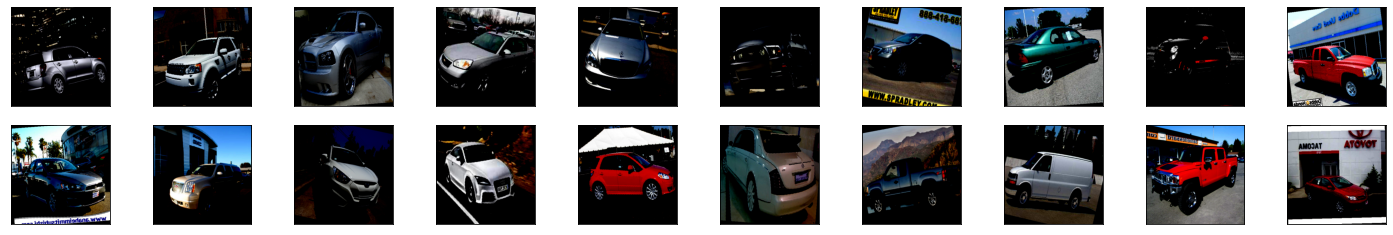

In [6]:
# ADD YOUR CODE HERE
# Visualize some sample data
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)));

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it.

#### Load the architecture

In [7]:
!nvidia-smi

Sat Jan 29 11:45:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# ADD YOUR CODE HERE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16 = models.vgg16(pretrained=True)
# print out the model structure
# print(vgg16)
# print(vgg16.classifier[6].in_features) 
# print(vgg16.classifier[6].out_features)

cuda:0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 196)
vgg16.classifier[6] = last_layer
# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

196


In [10]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Define your optimizer and loss function

In [11]:
# ADD YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.1)

#### Train your network

In [12]:
# ADD YOUR CODE HERE
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    valid_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model, validloader)
        valid_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, valid_accuracies

In [13]:
def eval_model(model, loader):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [14]:
# ADD YOUR CODE HERE
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [15]:
model_ft, training_losses, training_accs, valid_accs = train_model(vgg16, criterion, optimizer,
                                                                  lrscheduler, n_epochs=15)

Epoch 1, duration: 708 s, loss: 4.8323, acc: 4.2126
Accuracy of the network on the test images: 2 %
Epoch 2, duration: 340 s, loss: 4.1203, acc: 9.9571
Accuracy of the network on the test images: 8 %
Epoch 3, duration: 349 s, loss: 3.8728, acc: 12.7604
Accuracy of the network on the test images: 10 %
Epoch 4, duration: 350 s, loss: 3.6063, acc: 17.0343
Accuracy of the network on the test images: 8 %
Epoch 5, duration: 349 s, loss: 3.4652, acc: 20.4197
Accuracy of the network on the test images: 13 %
Epoch 6, duration: 350 s, loss: 3.3714, acc: 21.6759
Accuracy of the network on the test images: 18 %
Epoch 7, duration: 350 s, loss: 3.2476, acc: 24.3260
Accuracy of the network on the test images: 15 %
Epoch 8, duration: 351 s, loss: 3.2073, acc: 25.1685
Accuracy of the network on the test images: 16 %
Epoch 9, duration: 350 s, loss: 3.1751, acc: 26.3327
Accuracy of the network on the test images: 17 %
Epoch 10, duration: 349 s, loss: 3.1177, acc: 27.7880
Accuracy of the network on the te

In [16]:
torch.save(model_ft.state_dict(), './vgg16_model.h5')

#### Show results (accuracy and loss) on training and validation sets

## 3. Conclusion

#### Evaluate your model

In [17]:
# ADD YOUR CODE HERE
model_ft.load_state_dict(torch.load('./vgg16_model.h5'))
test_accuracy = eval_model(model_ft, testloader)

Accuracy of the network on the test images: 29 %


Text(0.5, 1.0, 'Valid acc')

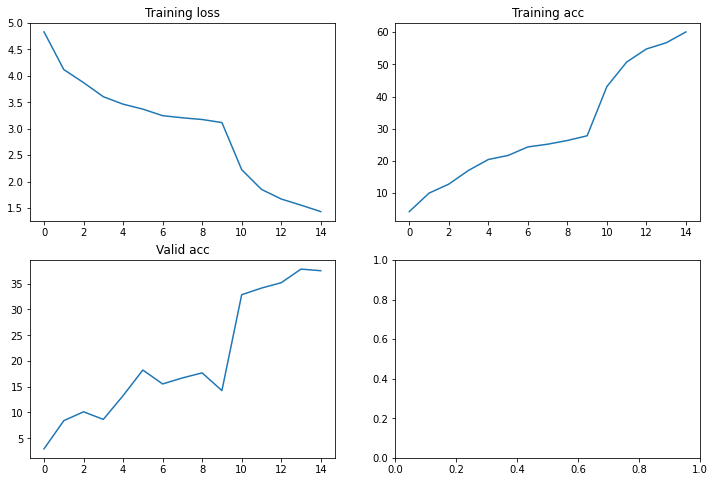

In [18]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(valid_accs)

axarr[1, 0].set_title("Valid acc")

#### Show some predictions

In [19]:
# ADD YOUR CODE HERE
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

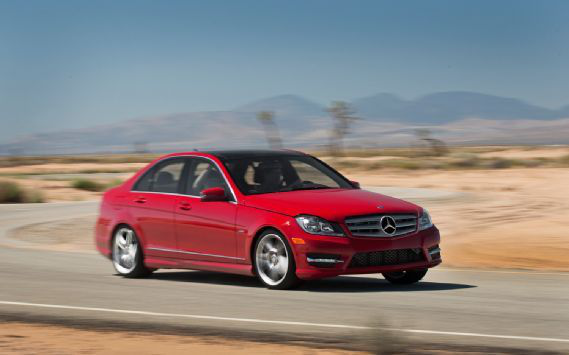

Predicted Class is :  Volkswagen Beetle Hatchback 2012
Ground Truth Class  Mercedes-Benz C-Class Sedan 2012


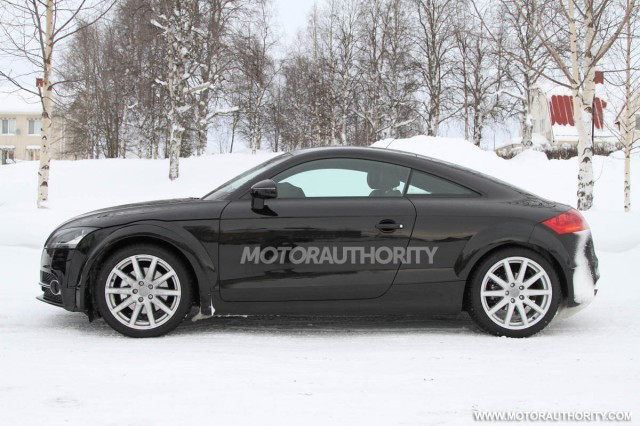

Predicted Class is :  Audi R8 Coupe 2012
Ground Truth Class  Audi TT Hatchback 2011


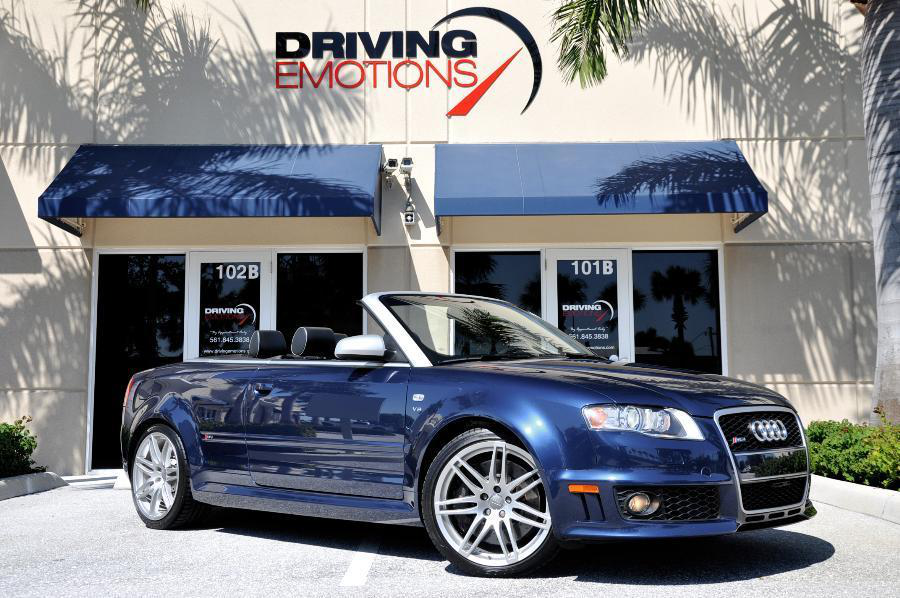

Predicted Class is :  Audi RS 4 Convertible 2008
Ground Truth Class  Audi RS 4 Convertible 2008


In [20]:
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
images_to_show = ['test/Mercedes-Benz C-Class Sedan 2012/01977.jpg',
                  'test/Audi TT Hatchback 2011/00450.jpg', 
                  'test/Audi RS 4 Convertible 2008/00112.jpg']
i = 0
for img in images_to_show :
    image = Image.open(dataset_dir+img)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model_ft(image)
    conf, predicted = torch.max(output.data, 1)
    display(Image.open(dataset_dir+img))
    print('Predicted Class is : ', classes[predicted.item()])
    print('Ground Truth Class ', images_to_show[i].split('/')[1])
    i += 1